In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from rp_overlay import overlay
import rp
import os

In [2]:

# initialize FPGA and Red Pitaya
fpga = overlay()
rp.rp_Init()



Check FPGA [OK].


0

In [3]:

# generator parameters
channel = rp.RP_CH_1
waveform = rp.RP_WAVEFORM_ARBITRARY
freq = 10000
#sine_freq = 1 / 2e-6
ampl = 0.03

# burst mode settings
ncyc = 1     # only 3 cycle in the burst
nor = 1        # burst repeats only once
period = 10 # period between bursts 

gen_trig_sour = rp.RP_GEN_TRIG_SRC_INTERNAL

##### Acquisition #####
trig_lvl = 0.5
trig_dly = 0
dec = rp.RP_DEC_8    # 125 MHz / 8 = 15.625 MHz sample rate not much but i think this can increase the amount we capture for a little longer 
sample_rate = 125e6 / dec # / dec 
sample_rate_gen = 125e6 # / dec 
f0 = freq         
c = 1e9       
phi0 = 0.0          

acq_trig_sour = rp.RP_TRIG_SRC_AWG_PE  # using AWG (generator) as the trigger source

N = 16384  # number of samples, buffer


In [4]:
#waveform_duration = 

t = np.linspace(0, 1/freq, N)  # time from 0 to 100 ms

def linear_chirp_waveform(N, sample_rate, f0, c, phi0=0.0):
    t = np.arange(N) / sample_rate
    #  x(t) = sin[phi0 + 2π*((c/2)*t^2 + f0*t)]
    return (.5-0.5*np.cos(phi0 + 2 * np.pi * ((c/2) * t**2 + f0 * t)))*(t<1e-4)


In [5]:
# prepare the waveform buffer
x = rp.arbBuffer(N)
x_temp = linear_chirp_waveform(N, sample_rate_gen, f0, c, phi0) #for linear chirp to be in the frequency we want it at 
for i in range(N):
    x[i] = float(x_temp[i])  


In [6]:
# reset the generator and acquisition system
rp.rp_GenReset()
rp.rp_AcqReset()


0

In [7]:

###### Generation #####
print("Gen_start")
rp.rp_GenWaveform(channel, waveform)
rp.rp_GenArbWaveform(channel, x.cast(), N)  # load the custom sine wave into the generator
rp.rp_GenFreqDirect(channel, freq)
rp.rp_GenAmp(channel, ampl)

# set burst mode properties
rp.rp_GenMode(channel, rp.RP_GEN_MODE_BURST)
rp.rp_GenBurstCount(channel, ncyc)  # single cycle burst
rp.rp_GenBurstRepetitions(channel, nor)  # single repetition
rp.rp_GenBurstPeriod(channel, period)  

# trigger source for the generator
rp.rp_GenTriggerSource(channel, gen_trig_sour)

# enable output sync (keep signals in sync when triggered)
rp.rp_GenOutEnableSync(True)


Gen_start


0

In [8]:
rp.rp_AcqSetDecimation(dec)

# Set trigger level and delay
rp.rp_AcqSetTriggerLevel(rp.RP_T_CH_1, trig_lvl)
rp.rp_AcqSetTriggerDelay(trig_dly)

# Start Acquisition
print("Acq_start")

# start acquisition --> trigger based on the AWG burst
rp.rp_AcqStart()


# Specify trigger - input 1 positive edge
rp.rp_AcqSetTriggerSrc(acq_trig_sour)

time.sleep(1)

rp.rp_GenTriggerOnly(channel)       # Trigger generator

print(f"Trigger state: {rp.rp_AcqGetTriggerState()[1]}")


# wait until the buffer is filled then empty before capturing the next sequence
while True:
    trig_state = rp.rp_AcqGetTriggerState()[1]
    if trig_state == rp.RP_TRIG_STATE_TRIGGERED:
        break
print(f"Fill state: {rp.rp_AcqGetBufferFillState()[1]}")


while True:
    if rp.rp_AcqGetBufferFillState()[1]:
        break


Acq_start
Trigger state: 0
Fill state: True


In [ ]:
#need to click ctrl c to capture 
try:
    while True:
        # fetch the data for the first sequence (sequence A)
        data_VA = np.zeros(N, dtype=float)
        fbuff_A = rp.fBuffer(N)
        rp.rp_AcqGetOldestDataV(rp.RP_CH_1, N, fbuff_A)
        for i in range(N):
            data_VA[i] = fbuff_A[i]
        
        
        # wait until the buffer is empty before capturing the next sequence
        #while rp.rp_AcqGetBufferFillState()[1]:
        #    pass
        
        # second acquisition - sequence B (trigger another burst)
        rp.rp_AcqStart()
        # Specify trigger - input 1 positive edge
        rp.rp_AcqSetTriggerSrc(acq_trig_sour)
        
        rp.rp_GenTriggerOnly(channel)
        
        # wait for the trigger event for sequence B
        while rp.rp_AcqGetTriggerState()[1] != rp.RP_TRIG_STATE_TRIGGERED:
            pass
        
        # wait for the buffer to fill for sequence B
        while not rp.rp_AcqGetBufferFillState()[1]:
            pass
        
        # fetch the data for the second sequence (sequence B)
        data_VB = np.zeros(N, dtype=float)
        fbuff_B = rp.fBuffer(N)
        rp.rp_AcqGetOldestDataV(rp.RP_CH_1, N, fbuff_B)
        for i in range(N):
            data_VB[i] = fbuff_B[i]
        time.sleep(1)

except KeyboardInterrupt:
    print("acquisition loop interrupted.")




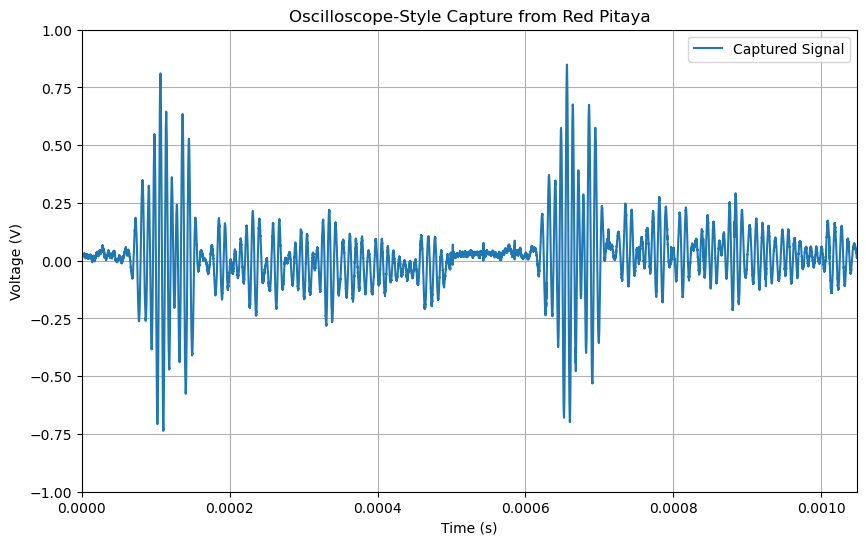

In [10]:
time_axis = np.arange(N) / sample_rate

plt.figure(figsize=(10, 6))
plt.plot(time_axis, data_VB, label="Captured Signal")
plt.xlim([time_axis[0], time_axis[-1]])    
plt.ylim([-1, 1])       
plt.title("Oscilloscope-Style Capture from Red Pitaya")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.legend()
plt.show()




In [11]:
save_dir = r"stick_tube1"

#/tmp/
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the arrays
np.save(os.path.join(save_dir, "data_VA.npy"), data_VA)
np.save(os.path.join(save_dir, "data_VB.npy"), data_VB)


plot_path = os.path.join(save_dir, "last_capture1.png")
plt.savefig(plot_path, dpi=300)

print(f"Data and plot saved to: {save_dir}")
print("Files created: data_VA.npy, data_VB.npy, last_capture1.png")

Data and plot saved to: stick_tube1
Files created: data_VA.npy, data_VB.npy, last_capture1.png


<Figure size 640x480 with 0 Axes>

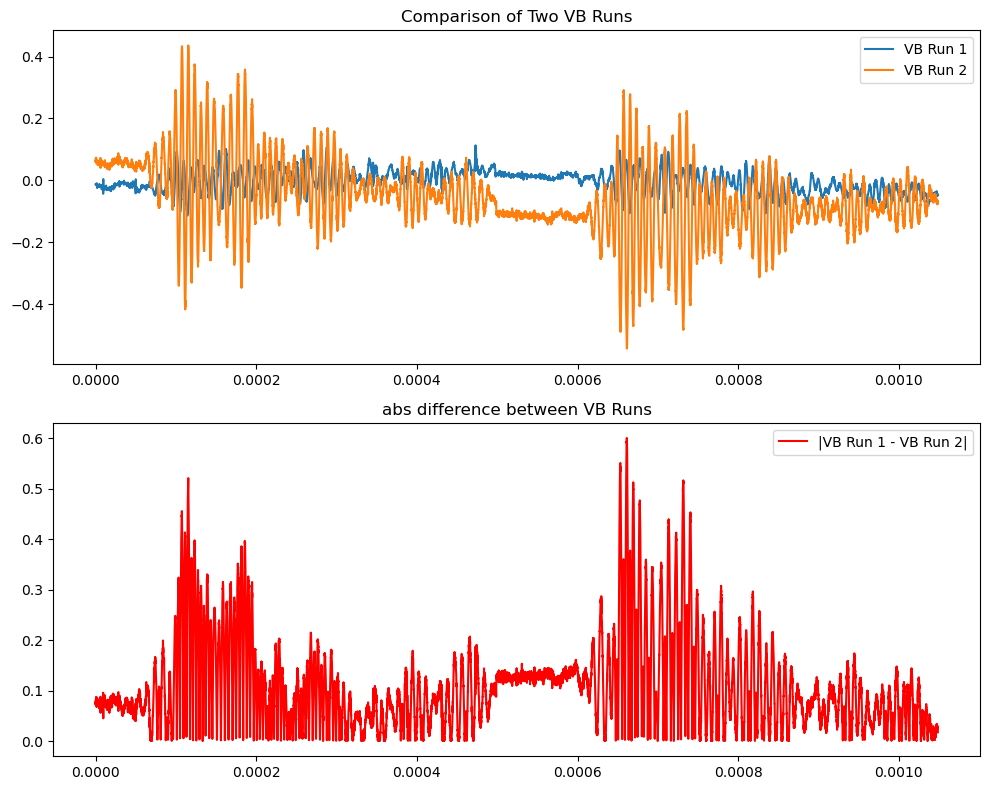

In [12]:
file1 = r"/home/jupyter/RedPitaya/sbcnorthwestern/data_runs/stick_tube1/data_VB.npy"
file2 = r"/home/jupyter/RedPitaya/sbcnorthwestern/data_runs/water_tube1/data_VB.npy"

if not os.path.exists(file1):
    print("File 1 not found:", file1)
if not os.path.exists(file2):
    print("File 2 not found:", file2)

vb1 = np.load(file1)
vb2 = np.load(file2)
diff_vb = np.abs(vb1 - vb2)
   
# plot the two VB runs and their difference
time_axis = np.arange(N) / sample_rate
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(time_axis, vb1, label="VB Run 1")
ax[0].plot(time_axis, vb2, label="VB Run 2")
ax[0].set_title("Comparison of Two VB Runs")
ax[0].legend()
ax[1].plot(time_axis, diff_vb, label="|VB Run 1 - VB Run 2|", color="red")
ax[1].set_title("abs difference between VB Runs")
ax[1].legend()
plt.tight_layout()
plt.show()


# release resources when done
rp.rp_Release()
